# Project 2 report: Scotland Road Traffic Analysis
Author:  Liyi Fan,  Dongrui Shen,  Zhier Chen,  Peixuan He

## Setup

In [1]:
#  pip install folium  # uncomment it to install folium

In [2]:
# Load the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')  # set plot style
import seaborn as sns
from matplotlib import cm
from IPython.core.display import HTML
import folium
import helper.data as dt  # `helper` module contains all wrapped functions we used to assist our analysis
import helper.visual as vs
import helper.decision as dc

## Overview

The main purpose of this report is to estimate the traffic volumes for the past 20 years and help DfT determine where to put counters next year.

The report is organized as follows. In the following section, we firstly preprocessed the manual counts dataset and give a briefly description about it. Next, we focused on setting up a criterion to measure the busyness of road links. We described the standard traffic volume formula used by the UK government and proposed two estimated traffic volume formulae. We calculated the traffic volume and gave the ranking of road links for each of the two estimated traffic volume formulae. For the second estimation method, we also provided interactive codes so that you can find out any number of "valuable" counting points that you want in the map.

## Dataset details

Data we processed in this report is from the Department for Transport (DfT), which contains the data for all manual counts performed on Scottish roads from 2000 to 2019. Each row represents the observation data for a specific hour in different days at different counting point in a specific direction. 


#### Preprocess manual count data
We firstly wrote a function `read_data` to convert the manual counting data file to a well-presented dataframe. In this dataframe, we added a column named `name_type` to indicate the road categories and dropped irrelevant columns.

In [3]:
# Read and preprocess manual count data
df = dt.read_data("dft_rawcount_region_id_3.csv")
# Pretty print dataframe in jupyter notebook
dt.view(df)  # display the first 5 rows

,count_point_id,direction_of_travel,year,count_date,hour,local_authority_id,local_authority_name,road_name,road_type,start_junction_road_name,end_junction_road_name,latitude,longitude,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,name_type
0,931907,N,2019,2019-06-17,18,29,City of Edinburgh,U,Minor,NaN,NaN,55.967806,-3.30758,NaN,NaN,8,2,290,5,20,0,317,U
1,931907,S,2019,2019-06-17,13,29,City of Edinburgh,U,Minor,NaN,NaN,55.967806,-3.30758,NaN,NaN,1,1,258,4,36,7,306,U
2,931907,N,2019,2019-06-17,9,29,City of Edinburgh,U,Minor,NaN,NaN,55.967806,-3.30758,NaN,NaN,5,1,270,5,44,8,328,U
3,931907,S,2019,2019-06-17,12,29,City of Edinburgh,U,Minor,NaN,NaN,55.967806,-3.30758,NaN,NaN,2,2,266,4,50,9,331,U
4,931907,S,2019,2019-06-17,10,29,City of Edinburgh,U,Minor,NaN,NaN,55.967806,-3.30758,NaN,NaN,4,0,247,8,35,8,298,U


#### How many counting points did DfT set?
In order to get a sense of how counting points were set for the past 20 years, we defined a function `counter_stat` to count the number of counting points each year and considered two types of groups separately. One is the major roads and the other one is the minor roads. 

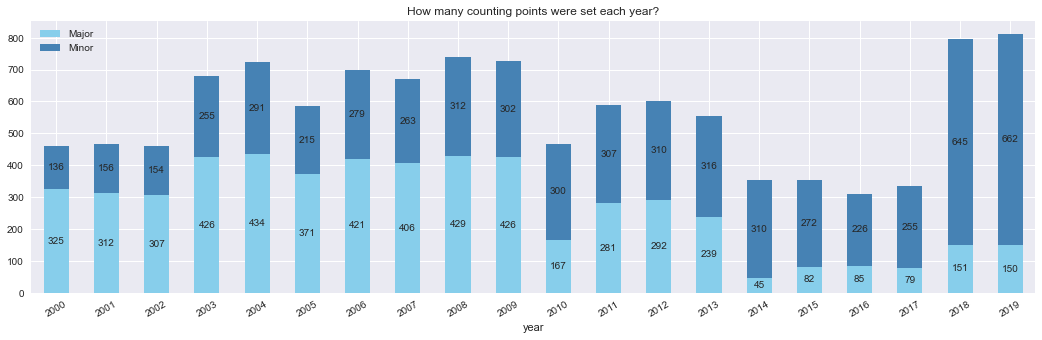

In [17]:
# Compute how many counting points were set on major roads and minor roads each year.
# Make a stacked bar plot to show trend.
cpdf = vs.counter_stat(df)

We firstly observed that the number of counting points for each year increased with fluctuations from 2000 to 2009, and then decreased from 2012 to 2017, but more than doubled in 2018. For major roads, the number of counting points firstly around 300 to 430 during year 2000 to 2009, but then suddenly decreased in 2010 and kept it around 150 to 300, then decreased again in 2013, which failed to less then 100. It finally turned back to around 150 in year 2018 and 2019. However, for minor roads, it's interesting to find that the number of counting points was increasing with slightly fluctuation and exceeded it for major roads in 2010.

## Problem: Which road link is the busiest?

Counters should be sent to the most "valuable" places. We regarded "valuable" here as the "busiest" places with "effective" time. We considered "busiest" not only by counting the daily average number of vehicles observed by each counting point per year, but also considered the link length. By combining these two factors together, we rasied the definition of traffic volume:
$$
\mathrm{Traffic_{\,CP}} = \mathrm{AADN_{\,CP}} \times \mathrm{Length_{\,link}} \times 365.
$$

We first considered "effective" as data available. Alternatively, we explained "effective" by using the following formula calculating penalized traffic volume:

\begin{align}
\mathrm{avg_{\,weighted}} &= \sum_{i=1}^n \frac{i}{\sum_{i=1}^n i}{\mathrm{Traffic^{\,2020-i}_{\,CP}}}. \\
&= \frac{2}{(1+n)n}\mathrm{{Traffic^{\,2020-n}_{\,CP}}} + \frac{4}{(1+n)n}\mathrm{{Traffic^{\,2020-(n-1)}_{\,CP}}} + ... + \frac{2n}{(1+n)n}\mathrm{{Traffic^{\,2020-1}_{\,CP}}}
\end{align}
Here, n means the number of years we choose.

We mainly divided this problem into three parts: 
1. The first part analyzed the daily average observation of vehicles and pedal cycles in different type of roads: A, B, M, C, U, which can give us a general understanding of the total vehicle numbers in each road and the trend for the passing 20 years. 
2. In the second part, we analyzed it much "deeper". We analyzed the daily average observation based on each counting point. We emulated the model given by UK government which can be used to calculate the traffic volumes, which can help us determine which road is busier.
3. In the final part, we further modified the model we used in part 2 by measuring the busy degree with the penalized traffic volume. We provide an interactive code at the end to help DfT find out those busy road sections.

#### Remark on daily traffic volume

UK government usually calculates the yearly traffic volume for each counting point as:

$$
\mathrm{Traffic_{\,CP}} = \mathrm{AADF_{\,CP}} \times \mathrm{Length_{\,link}} \times 365,
$$

also, calculating the traffic volume of all counting points in one year as: $\mathrm{Total\,traffic} = \sum \mathrm{Traffic_{\,CP}}$. [2]

Here AADF is the annual average daily flows, but calculated with information from a network of automatic traffic counters (ATCs), which we cannot accessed. Thus, we modified the first formula to:

$$
\mathrm{Traffic_{\,CP}} = \mathrm{AADN_{\,CP}} \times \mathrm{Length_{\,link}} \times 365.
$$

where AADN is the annual average daily number of all vehicles.

Since minor roads in our data set do not have link length, we calculated as the following for minor roads: $
\mathrm{Traffic_{\,CP}} = \mathrm{AADN_{\,CP}}  \times 365.
$

### Part 1: Annual average daily vehicle number (AADN)

In this part, we will explore how the number of vehicles for different road categories changed by year.

#### Road categories

According to the road classification defined by UK government [1], we regarded M-roads and A-roads as our major roads, while B, C and U-roads as minor roads in our report.

- Major roads: Includes motorways (M-roads) and all A-roads. These roads usually have high traffic flows and are often the main arteries to major destinations.
- Minor Roads: These are B and C classified roads and unclassified roads.

The number of vehicles can be quite different to pedal cycles in different types of roads. For example, we cannot ride bicycles on motorways while some kinds of vehicles may not possible to pass on some very small roads. Thus, we considered the daily observation into two parts to see how busy it was for different type of roads: one is all the vehicles but pedal cycles and the other one is pedal cycles.

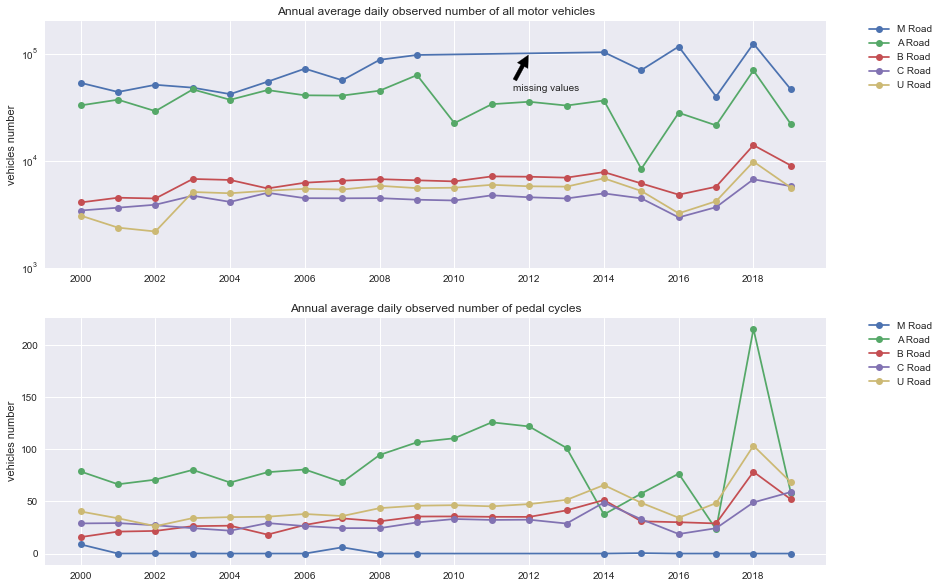

In [5]:
# Annual daily vehicle number by road categories
vs.AADN_cat(df)

For both daily average observation for motor vehicles and pedal cycles, the trends of B-roads, C-roads and U-roads were quite similar. Also, the observation in all of the roads for both vehicles and pedal cycles rised in 2018, which is probably because the doubled number of counting points in 2018.

For the daily average observation for motor vehicles, M-roads and A-roads were larger than that of another three roads from 2000 to 2019. However, M-roads did not have any records from 2010 to 2013. We pointed this as the "missing value" in the graph. The observation number also decreased and kept in a level for A-roads during 2010 to 2013. This is probably the consequence of the suddenly decreased number of counting point during 2010 to 2013, which has been pointed out in the Overview section. In addition, the daily observation also had a sharp decrease for A-roads in 2015.

For the daily average observation for pedal cycles, the number of observation was quite less than which for vehicles. It's not surprisingly to find that the observation was almost 0 in M-roads. Moreover, we can observe that the daily observation on A-roads was always the largest, except for year 2014, 2017 and 2019. The observation value on the A-roads increased by nearly 5 times.

### Part 2:  Annual average traffic volume

In this part, we analyzed "how busy" of different links in each road by comparing the annual average traffic volume of different links. It should be noted that all comparisons are based on road sections without missing data. Instead of calculating the total traffic volume, we used the average of existing value to measure the magnitude of traffic volume for a year.

In [19]:
# Caculate the traffic volume of all road links with data for one certain year.
dt.view(dt.TV(df))

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count_point_id,,,,,,,,,,,,,,,,,,,,
700,NaN,85469903.8,NaN,83318988.0,92689888.5,NaN,94817604.9,96088600.6,94093452.2,NaN,NaN,NaN,NaN,NaN,95157310.4,NaN,NaN,NaN,NaN,NaN
701,NaN,55976400.0,NaN,63288810.0,NaN,59034078.0,68828634.0,55493505.0,60724539.0,57925719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702,NaN,28501974.0,NaN,27488880.0,NaN,29713482.0,NaN,28400796.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31352040.0,NaN,NaN,NaN
703,NaN,NaN,NaN,9535698.0,NaN,NaN,10020235.5,NaN,13789291.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14668780.6,NaN,NaN,NaN
704,NaN,8098160.1,NaN,NaN,NaN,NaN,9160682.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11370195.3,NaN,NaN,NaN,NaN


We then made the following line chart, which can show the trend of the annual average traffic volume (in terms of counting points) for major roads and minor roads during 2000 to 2019. When calculating the annual average estimation, we only used the traffic volume for those counting points that had data (not NAN), then divided the number of those counting points.

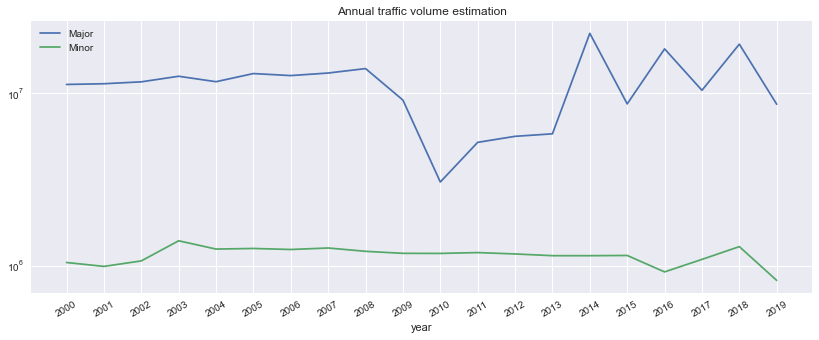

In [7]:
dfs = vs.TV_stat(df)

We can see that the annual traffic volume estimation for major road is much larger than that in minor road. Also, by using the log-number of our traffic volume estimation, we can see the changes clearer. The most obvious decreasing was happened in 2010. If you look back for the counting points number before, you may find that the number of counting points in 2010 have been halved.

Next, we used the annual "average" number to estimate the "busy level" of each counting point. Similarly, we only counted for those year having data, and then subtracted the number of years with NAN data when calculating the denominator. Since we did not consider the length of minor roads, we gave the top 5 busiest counting points in major roads and minor roads separately.

In [8]:
cpdf = dt.cp_info(df).set_index(['count_point_id'])  # get counting points information

In [9]:
mtemp = dt.TV(df, type='Major') # compute traffic volume
# find the top 5 busiest counting points on major roads
busylink = mtemp.apply(lambda row: np.mean(row[~np.isnan(row)]), 
                      axis=1).sort_values(ascending=False).to_frame(name='TV').head()
m_cpls = busylink.index.tolist()
# merge the counting points information with the TV
busym = pd.concat([busylink,cpdf.loc[m_cpls,]],axis=1).sort_values(by='count_point_id')
print("The top 5 busiest counting points for major roads: ")
busym

The top 5 busiest counting points for major roads: 


,TV,road_name,name_type,latitude,longitude
count_point_id,,,,,
700,9.166225e+07,M8,M,55.927220,-3.441936
10768,8.376794e+07,A90,A,56.426074,-3.217554
20700,9.241957e+07,M8,M,55.837029,-3.925646
90101,9.264999e+07,M8,M,56.000000,-4.000000
90102,8.916664e+07,M8,M,56.000000,-4.000000


In [10]:
ntemp = dt.TV(df, type='Minor') # compute traffic volume
# find the top 5 busiest counting points on minor roads
busylink = ntemp.apply(lambda row: np.mean(row[~np.isnan(row)]), 
                      axis=1).sort_values(ascending=False).to_frame(name='TV').head()
n_cpls = busylink.index.tolist()
# merge the counting points information with the TV
busyn = pd.concat([busylink,cpdf.loc[n_cpls,]],axis=1).sort_values(by='count_point_id')
print("The top 5 busiest counting points for minor roads: ")
busyn

The top 5 busiest counting points for minor roads: 


,TV,road_name,name_type,latitude,longitude
count_point_id,,,,,
811379,8.950530e+06,C,C,55.937762,-3.318158
812146,6.538245e+06,B7071,B,55.794729,-4.056474
931918,6.917334e+06,C,C,55.743214,-4.203172
990548,5.843650e+06,B8039,B,55.939678,-3.992063
996226,8.575654e+06,B902,B,56.018319,-3.792509


In [11]:
vs.counterloc(df,m_cpls) # make visualization for the busiest counting points on major roads

In [12]:
vs.counterloc(df,n_cpls) # make visualization for the busiest counting points on minor roads

It's interesting to find that we calculated top 5 busiest counting points for major roads, but there are only 4 points in the map. That is because there are two counting points with different id but same longitude and latitude.  This finding may slightly effect our analyzation, since our calculation for average busy level for each counting point is based on its counting point id. 

Thus, if the counting point has a large traffic volumn for these two years but a low traffic volumn for next two years, also, it has been counted as two different counting point id, then we may found that the average traffic volumn for the first counting point id is large but low for next. This is not what in actual happened.

However, we considered this as the special circumstance for their "large change", which is deserved to counted as a counting point. Thus, if the higher one is large enough to be counted for the counting point it is also reasonable. If the different id but same longitude and latitude happen for place that always has similar traffic volume, for example, 90101 and 90102 here, then no other consideration is needed.

### Part 3:  Penalized annual average traffic volume

In this part, we designed an interactive model to help decide where to set counters. Note that we used the penalized annual average traffic volume here. The number of the year that we would like to use for our data and the number of counters that we hope to have for major roads and minor roads can be decided by inputting the following box. The outputs contain two tables and a map. The first two tables tell us directly where the counters should be set on major roads and minor roads respectively. The map shows points in two colors. The blue points show the location of counting points on minor roads while green points show it for major roads.

In [13]:
# The aim is to find out where we should set counters
# It is according to average number of vehicles travelling per day in a given year (aadf)
# Two parts are considered seperately, major roads and minor roads
# The influence of data in the past 20 years are decided by weighted average method and how many data are used can be controled 
# How many counters set on major roads and minor roads can also controled manually. 

# aadf calculated by weighted average method
dfmajor_aadf, dfminor_aadf = dc.weighted_average_method(df)

# where to send counters
cmajor, cminor = dc.show_counters(dfmajor_aadf, dfminor_aadf)

# plot the locations needing counters
dc.plot_map(cmajor, cminor)


How many years of statistics are taken into consideration (an integer less than or equal to 20): 20
how many counters are set on major road: 20
how many counters are set on minor road: 10
the counters on major roads should be set at: 
     latitude  longitude
0   55.866081  -4.226141
1   55.869385  -4.243721
2   55.866178  -4.271506
3   56.000000  -4.000000
4   55.808790  -4.059896
5   56.013029  -3.403426
6   55.870078  -4.254950
7   55.898721  -3.218572
8   55.867126  -4.365624
9   55.860952  -4.404642
10  55.961201  -3.289672
11  55.866537  -4.362152
12  55.940097  -3.319134
13  55.938568  -3.384722
14  55.861038  -4.105808
15  55.867747  -4.210061
16  55.789408  -4.036542
17  55.849440  -4.301682
18  55.931735  -3.089956
19  55.921269  -3.306716


the counters on minor roads should be set at: 
    latitude  longitude
0  56.018319  -3.792509
1  55.743214  -4.203172
2  55.939678  -3.992063
3  55.850801  -3.975211
4  55.907177  -3.226675
5  55.930565  -3.285837
6  57.140592  -2.138878

When all of the 20 years'statistics are used, 20 counters on major roads are needed and 10 counters on minor roads are needed, from the map, the conclusion can be drawn that:
1. When considering the major roads, most counters are set on M8 road, and they are collective.
2. When considering the minor roads, the counters are scattered.
3. Almost all of the locations are at city center or near the coast.

For major roads, it is possibly to appear that many counting points are displayed on the same road. This is because the major roads are usually very long and are distributed in the city center or near the coast. However, for minor roads, since they do not have link length in our data set, there will only contain one counting point for each minor road. This may be the reason why they seem scattered on the map.

In [20]:
# Set counters on M8 road
dc.show_counters_M8(dfmajor_aadf)

how many counters are set on road M8: 20
The counters on the major roads should be set at:
     latitude  longitude
0   55.866081  -4.226141
1   55.869385  -4.243721
2   55.866178  -4.271506
3   56.000000  -4.000000
4   55.870078  -4.254950
5   55.867126  -4.365624
6   55.860952  -4.404642
7   55.866537  -4.362152
8   55.861038  -4.105808
9   55.867747  -4.210061
10  55.849440  -4.301682
11  55.863698  -4.355586
12  55.854702  -4.270037
13  55.873028  -4.191179
14  55.863457  -4.121920
15  55.849422  -4.312225
16  55.927220  -3.441936
17  56.000000  -4.000000
18  55.861519  -4.435202
19  55.849738  -4.285723


More specifically, since M8 seems really busy and many points should be set on it, we would like to draw the counting points displayed on M8 independently. Similarly, you can input the number you'd like to set the counting points on M8.

Here we put 10 counting points on M8 on the above map, from which we can see that all counters are collective at the city center, but only one is far away.

## Other interesting facts

#### Annual daily vehicle number by vehicle types

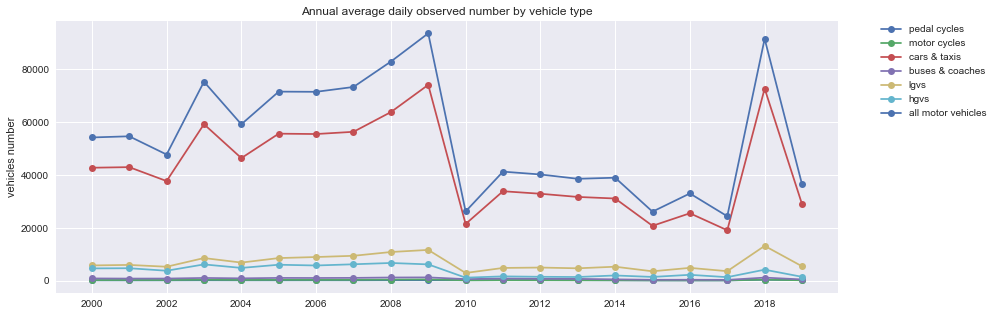

In [15]:
# Annual daily vehicle number statistics by vehicle types
vs.AADN_veh(df,logscale=False)

As the economy develops, people are more capable of choosing more comfortable transportation. So we can find that in the figure above, the number of cars and taxis was the largest for all 20 years in all of the vehicles, and the number of Igvs turned next.

#### Major road length computation

Assuming that every link (section) of a major road is associated to a counting point in the data, the length of major roads can be estimated by summing all of the relevant links to give a total road length. 

In [16]:
# Caculate the length of all roads (of one certain type) with data for one certain year.
print("Longest A-roads and M-roads")
Alen = dt.roadlen(df,nametype='A').head().reset_index()
Mlen = dt.roadlen(df,nametype='M').head().reset_index()
dt.view(pd.concat([Alen,Mlen],axis=1))

Longest A-roads and M-roads


,road_name,road_length_km,road_length_miles,road_name,road_length_km,road_length_miles
0,A9,445.2,276.64,M74,122.49,76.11
1,A90,277.1,172.18,M8,99.30,61.68
2,A82,274.0,170.26,M90,54.60,33.92
3,A836,194.3,120.73,M9,46.40,28.83
4,A832,184.2,114.47,M77,39.01,24.25


Accordidng to literature, our estimates for the length of major roads should be essentially correct. A9 is indeed the longest road in Scotland. However, instead of M74, M8 should be the longest motorways in Scotland. Besides, the literature length for M74 is 40 miles. This error could result from the fact that the counting point id of some road sections may be variant in different years. Using `count_point_id` to distinguish different road links might be convenient but sometimes it is not reliable.

## Reference

[1]   [Road Lengths in Great Britain Statistics: Notes and Definitions](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/860022/road-length-notes-definitions.pdf)

[2]   [Road traffic estimates: Methodology note](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/524848/annual-methodology-note.pdf)